In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [6]:
#Data Preprocessing
#This section of code uses the code from https://github.com/AyanPahari/SVM-on-GISETTE-Dataset

fil= open("gisette_train.data") #opening the file
X_train=[]
for row in fil.readlines(): #reading the file line by line
    X_train.append((row.strip()).split()) #to get the values tuple by tuple without any whitespaces
fil.close()
#after this train will contain all the data in form of a numpy array

#repeating the same thing for test and valid samples as well

fil= open("gisette_train.labels")
y_train=[]
for row in fil.readlines():
    y_train.append((row.strip()).split())
fil.close()

fil= open("gisette_valid.data")
X_test=[]
for row in fil.readlines():
    X_test.append((row.strip()).split())
fil.close()

fil= open("gisette_valid.labels")
y_test=[]
for row in fil.readlines():
    y_test.append((row.strip()).split())
fil.close()

#some type conversions
X_train=np.array(X_train).astype(int)
y_train= np.array(y_train).astype(int)[:,0]

#some type conversions
X_test=np.array(X_test).astype(int)
y_test= np.array(y_test).astype(int)[:,0]

In [7]:
#converting from numpy array to pandas dataframe
X = pd.DataFrame(X_train)
y = y_train
val_train = pd.DataFrame(X_test)
val_test = y_test

In [8]:
import sklearn
from sklearn import preprocessing

In [9]:
#Data Scaling to [-1,1] for Logistic Regression

X_np = np.array(X)
minmaxscaler = preprocessing.MinMaxScaler(feature_range = (-1,1))
minmaxscaler.fit(X_np)
X_np_scaled = minmaxscaler.transform(X_np)

In [10]:
#Random Permutation
perm = np.random.permutation(X_np_scaled.shape[0])
new_range = perm[:2000]

#Picking only 2000 samples to match results from paper
X_new_np_scaled = X_np_scaled[new_range]
y_new = y[new_range]

In [11]:
#Activation function and Prediction Accuracy Fn

def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

def prediction_accuracy(X,y,w):
    z = np.matmul(X,w)
    preds = sigmoid(z)
    y_hat = np.zeros(y.shape[0])
    for i in range(len(preds)):
        if preds[i]>0.5:
            y_hat[i] = 1
        else:
            y_hat[i] = -1
    y_hat = np.array(y_hat)
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count+=1
    acc = count/y.shape[0]
    return acc

In [12]:
#Cost Function

def LogisticCost(X,y,w):
    z = -np.matmul(X,w)*y
    m = X.shape[0]
    cost = (1/m)*np.sum(np.log(1+np.exp(z)))
    return cost   

In [13]:
#Away Step FW functions for Logistic Regression 

def gradient_AFW(X,y,w): #gradient of func
    z = -np.matmul(X,w)*y
    dz = np.exp(z)/(1+np.exp(z))
    dw = -(1/X.shape[0])*np.matmul(X.T,dz*y)
    return dw
        
def LP_LR_AFW_min(X,y,w,S): #Frank Wolfe Step
    idx = np.argmax(np.abs(gradient_AFW(X,y,w)))
    sign = np.sign(gradient_AFW(X,y,w)[idx])
    return -sign*S[:,idx],idx

def LP_LR_AFW_max(X,y,w,S): #Away Step
    S_matrix = []
    S_indices = []
    for key,value in S.items():
        S_matrix.append(value)
        S_indices.append(key)
    S_matrix = np.array(S_matrix)
    idx = np.argmax(np.matmul(S_matrix,gradient_AFW(X,y,w)))
    return S_matrix[idx],S_indices[idx]

In [21]:
#Away Steps FW for Logistic Regression

def FW_awaysteps_LR(w_init,epsilon1,epsilon2,S,alpha_0,L,X,y,max_iter):
    w_0,index = LP_LR_AFW_min(X,y,w_init,S)
    alpha_0[index] = 1
    S_0 = {}
    S_0[index] = w_0
    it = 0
    flag = None
    itr = []
    fn_values = []
    endFlag = False
    count1 = 0 #No of drop Steps
    count = 0 #No of away step choices
    while (it<=max_iter):
        vt_FW,i_FW = LP_LR_AFW_min(X,y,w_0,S) #FW step
        vt_A,i_A = LP_LR_AFW_max(X,y,w_0,S_0) #Away Step
        if np.dot(gradient_AFW(X,y,w_0),w_0-vt_FW)>=np.dot(gradient_AFW(X,y,w_0),vt_A-w_0): #Stopping Criterion
            d_t = w_0 - vt_FW
            gamma_max = 1
            flag = True
        else:
            d_t = vt_A - w_0
            gamma_max = alpha_0[i_A]/(1-alpha_0[i_A])
            count +=1 
            flag = False
        gamma_t = max(0,min(np.dot(gradient_AFW(X,y,w_0),d_t)/(L*(np.linalg.norm(d_t)**2)),gamma_max))
        w_0 = w_0 - gamma_t*d_t
        if np.dot(gradient_AFW(X,y,w_0),w_0-vt_FW)>=np.dot(gradient_AFW(X,y,w_0),vt_A-w_0):
            alpha_0 = (1-gamma_t)*alpha_0
            if i_FW in S_0:
                alpha_0[i_FW] = alpha_0[i_FW]+gamma_t
            else:
                alpha_0[i_FW] = gamma_t
            if gamma_t <(1-epsilon1):
                S_0[i_FW] = vt_FW
            elif gamma_t > 1-epsilon1:
                S_0.clear()
                S_0[i_FW] = vt_FW
        else:
            alpha_0 = (1+gamma_t)*alpha_0
            if i_A in S_0:
                alpha_0[i_A] = alpha_0[i_A]-gamma_t
            if abs(gamma_t-gamma_max)<20*epsilon2: #tol to ensure weight zeroing 
                alpha_0[i_A] = 0
                S_0.pop(i_A)
                count1+=1 
        if it%100 == 0:
            print("Cost,gamma_t",LogisticCost(X,y,w_0),gamma_t,flag)
            alpha_lr[np.where(alpha_lr!=0)[0]]    
        itr.append(it)
        fn_values.append(LogisticCost(X,y,w_0)) 
        it = it+1
        if abs(np.dot(gradient_AFW(X,y,w_0),(w_0-vt_FW)))<epsilon1: #Stopping Criterion
            endFlag = True
            break        
    return fn_values,itr,w_0,count,count1

In [22]:
#AFW Initialization

tol_epsilon = 0.001 
delta = 0.0001 #delta (from paper)
tau = 10 #Paper l1 norm constraint
L = 0.5 #Lipschitz (from paper)
w = np.zeros(X.shape[1])
l = np.random.permutation(X.shape[1])
w[l[0:10]]=1 #randomly assign 1 to 10 weight elements
w_init = w
S_lr = tau*np.identity(X.shape[1]) #Positive Vertices of l1 norm ball, tau previously defined
neg_S_lr = -S_lr #Negative vertices of l1 norm ball, tau as previously defined
S_new = np.hstack((S_lr,neg_S_lr)) #All Vertices
alpha_lr = np.zeros(S_new.shape[1]) #Weights for Away-Step vertices

fn_values_AFW,itr_AFW,w_updated_AFW,count,count_drop = FW_awaysteps_LR(w_init,delta,tol_epsilon,S_new,alpha_lr,L,X_new_np_scaled,y_new,500)

Cost,gamma_t 3.8225379699388604 0.0943476914029132 True
Cost,gamma_t 0.24041620042862838 0.0028458599739214145 True
Cost,gamma_t 0.20716386346757124 0.0019711432299299282 True
Cost,gamma_t 0.1887156404691056 0.0019658931519853963 False
Cost,gamma_t 0.17695278914355214 0.0012886677022050613 False
Cost,gamma_t 0.16890841166035472 0.0011652477886894505 False


In [23]:
print("No of drop steps in AFW:",count_drop)

No of drop steps in AFW: 1


In [25]:
#Prediction Accuracy for Away Step FW

test_data_transform = minmaxscaler.transform(np.array(val_train)) #scaling data with same transform

training_acc_AFW = prediction_accuracy(X_np_scaled,y,w_updated_AFW)
print("AFW Training Accuracy",training_acc_AFW)

test_acc_AFW = prediction_accuracy(test_data_transform,val_test,w_updated_AFW)
print("AFW Test Accuracy",test_acc_AFW)

AFW Training Accuracy 0.9398333333333333
AFW Test Accuracy 0.937


In [26]:
print("No of Feautures Selected by Away-Step FW:",len(np.where(w_updated_AFW!=0)[0]))

No of Feautures Selected by Away-Step FW: 55


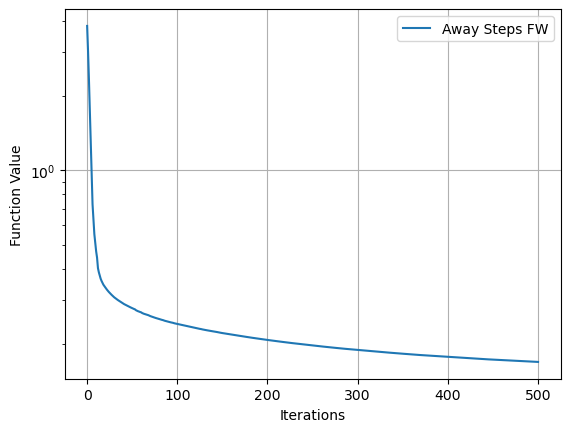

In [27]:
#Function-Value Plots

plt.semilogy(itr_AFW,fn_values_AFW, label = 'Away Steps FW')
plt.xlabel("Iterations")
plt.ylabel("Function Value")
plt.grid(True)
plt.legend(loc = 'upper right')